In [1]:
import tools.config as config
from tools.tools import nc_to_tif
import xarray as xr
import dill
import gzip

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_violin(arr, title="Value Distribution", save_path=None, value_range=None, logy=False):
    """
    画一个数组值的小提琴图，用于观察分布

    参数
    ----
    arr : numpy.ndarray 或 xarray.DataArray
        输入数组
    title : str
        图表标题
    save_path : str or None
        保存路径；None 时只显示不保存
    value_range : tuple or None
        (vmin, vmax)，只画这个范围内的值
    logy : bool
        是否把 y 轴设为对数坐标
    """
    # 转成 1D 并去掉 nan
    values = np.ravel(arr)
    values = values[~np.isnan(values)]

    # 如果指定范围，过滤
    if value_range is not None:
        vmin, vmax = value_range
        values = values[(values >= vmin) & (values <= vmax)]

    plt.figure(figsize=(6, 4))
    sns.violinplot(y=values, inner="box", linewidth=1.2)

    plt.title(title)
    plt.ylabel("Value")

    if logy:
        plt.yscale("log")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ 图已保存: {save_path}")
    else:
        plt.show()


# ==== 使用示例 ====
# arr = np.random.lognormal(mean=1, sigma=0.5, size=1000)
# 普通坐标
# plot_violin(arr, title="普通分布")
# 对数坐标
# plot_violin(arr, title="对数坐标", logy=True)


In [2]:
base_dir = f"../../../output/{config.TASK_NAME}/carbon_price/0_base_data"
tif_dir = f"../../../output/{config.TASK_NAME}/carbon_price/4_tif"
data_path = f"../../../output/{config.TASK_NAME}/Run_01_GHG_high_BIO_high_CUT_50/output/2025_09_08__09_33_05_RF5_2010-2050/Data_RES5.gz"

In [3]:
with gzip.open(data_path, 'rb') as f:
    data = dill.load(f)

In [26]:
env_categorys = config.carbon_names + config.carbon_bio_names
file_parts = ['total_cost','cost_ag', 'cost_agricultural_management', 'cost_non_ag', 'cost_transition_ag2ag_diff',
                 'transition_cost_ag2non_ag_amortised_diff','total','price']

In [12]:
input_path = f"{base_dir}/carbon_high/2050/xr_total_cost_carbon_high_amortised_2050.nc"
out_tif = f"{tif_dir}/total_cost_carbon_high_2050.tif"
da = xr.open_dataarray(input_path)

# nc_to_tif(data,da,out_tif)

In [29]:
for env_cat in env_categorys:
    for file_part in file_parts:
        print(f"Processing {env_cat} - {file_part}")
        if file_part == 'total_cost':
            input_path = f"{base_dir}/{env_cat}/2050/xr_{file_part}_{env_cat}_amortised_2050.nc"
        else:
            input_path = f"{base_dir}/{env_cat}/2050/xr_{file_part}_{env_cat}_2050.nc"
        out_tif = f"{tif_dir}/xr_{file_part}_{env_cat}_2050.tif"
        da = xr.open_dataarray(input_path)
        da = da.sum(dim=[d for d in da.dims if d != 'cell'])
        nc_to_tif(data,da,out_tif)

Processing carbon_low - total_cost
✅ 已保存: ../../../output/20250908_Paper2_Results_NCI/carbon_price/4_tif/xr_total_cost_carbon_low_2050.tif
Processing carbon_low - cost_ag
✅ 已保存: ../../../output/20250908_Paper2_Results_NCI/carbon_price/4_tif/xr_cost_ag_carbon_low_2050.tif
Processing carbon_low - cost_agricultural_management
✅ 已保存: ../../../output/20250908_Paper2_Results_NCI/carbon_price/4_tif/xr_cost_agricultural_management_carbon_low_2050.tif
Processing carbon_low - cost_non_ag
✅ 已保存: ../../../output/20250908_Paper2_Results_NCI/carbon_price/4_tif/xr_cost_non_ag_carbon_low_2050.tif
Processing carbon_low - cost_transition_ag2ag_diff
✅ 已保存: ../../../output/20250908_Paper2_Results_NCI/carbon_price/4_tif/xr_cost_transition_ag2ag_diff_carbon_low_2050.tif
Processing carbon_low - transition_cost_ag2non_ag_amortised_diff
✅ 已保存: ../../../output/20250908_Paper2_Results_NCI/carbon_price/4_tif/xr_transition_cost_ag2non_ag_amortised_diff_carbon_low_2050.tif
Processing carbon_low - total
✅ 已保存: ../..

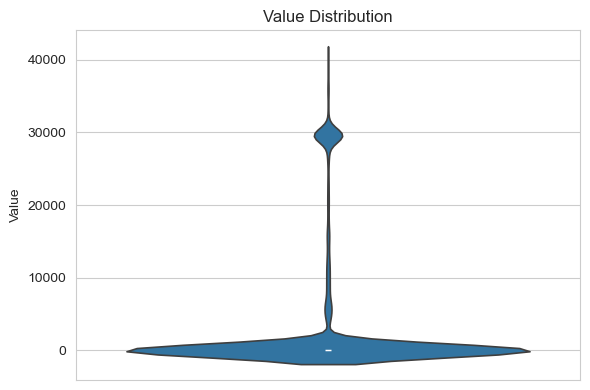

In [20]:
plot_violin(da.to_numpy(),value_range=(0,40000))

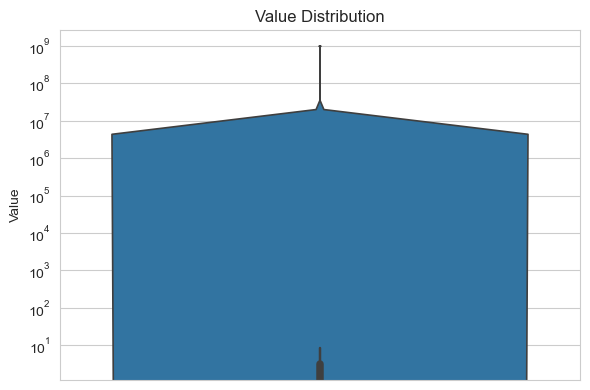

In [23]:
plot_violin(da.to_numpy(),logy=True)

In [35]:
out_tif = f"{tif_dir}/CP_BELT_AVG_T_CO2_HA.tif"
arr = data.CP_BELT_AVG_T_CO2_HA
da = xr.DataArray(
    arr,
    dims=["cell"],              # 维度名
    coords={"cell": np.arange(len(arr))},  # 坐标
    name="data"                 # DataArray 名称
)
nc_to_tif(data,da,out_tif)
          

✅ 已保存: ../../../output/20250908_Paper2_Results_NCI/carbon_price/4_tif/CP_BELT_AVG_T_CO2_HA.tif


In [41]:
path = r"N:\LUF-Modelling\LUTO2_XH\LUTO2\input\cp_block_avg_t_co2_ha_yr.h5"
ds = xr.open_dataset(path)
out_tif = f"{tif_dir}/CP_BELT_AVG_T_CO2_HA_raw.tif"


In [42]:
nc_to_tif(data,da,out_tif)

✅ 已保存: ../../../output/20250908_Paper2_Results_NCI/carbon_price/4_tif/CP_BELT_AVG_T_CO2_HA_raw.tif


In [44]:
import rasterio
def npy_to_map(input_arr, output_tif, proj_file,
               fill_value=np.nan, shift=0,
               dtype=rasterio.float32):
    """
    将一维 .npy 数组铺回到栅格地图中。
    - input_arr: path to .npy (1D array of length = number of valid pixels in proj_file)
    - output_tif: 输出 GeoTIFF 路径
    - proj_file: 用于投影和形状参照的已有 GeoTIFF
    - fill_value: 初始填充值（默认 np.nan）
    - shift: 在写入前对数据统一加的偏移量
    - dtype: 输出栅格的数据类型
    """
    # if not input_arr.lower().endswith(".npy"):
    #     return

    # 1) 读取参考栅格
    with rasterio.open(proj_file) as src:
        mask2D = src.read(1) >= 0
        transform = src.transform
        crs = src.crs
        profile = src.profile.copy()
        shape = src.shape

    # 2) 加载一维数组
    nonzeroes = np.where(mask2D)
    lumap = input_arr
    if lumap.ndim != 1:
        raise ValueError(f"{input_arr} 中的数组不是一维的")
    if len(lumap) != len(nonzeroes[0]):
        print(f"Warning: {input_arr} 的长度为 {len(lumap)}, proj_file 中有效像元数量为 {len(nonzeroes[0])}.")
        raise ValueError("lumap 的长度与 proj_file 中的有效像元数量不一致")

    # 3) 构建全图，并赋值
    themap = np.full(shape, fill_value=fill_value, dtype=float)
    themap[nonzeroes] = lumap + shift

    # 4) 把 +/- inf 都变成 np.nan
    themap[~np.isfinite(themap)] = np.nan

    # 5) 更新 profile 并写出
    profile.update({
        'dtype': dtype,
        'count': 1,
        'compress': 'lzw',
        'nodata': fill_value
    })
    with rasterio.open(output_tif, 'w', **profile) as dst:
        dst.write(themap.astype(dtype), 1)

    return output_tif

In [45]:
input_arr = da.to_numpy()
output_tif =  f"{tif_dir}/CP_BELT_AVG_T_CO2_HA_raw_res1.tif"
proj_file = r"N:\LUF-Modelling\LUTO2_XH\LUTO2\input\NLUM_2010-11_mask.tif"
npy_to_map(input_arr, output_tif, proj_file)

ValueError: lumap 的长度与 proj_file 中的有效像元数量不一致

In [48]:

ds = xr.open_dataset(path)

In [51]:
ds['data']

KeyError: "No variable named 'data'. Variables on the dataset include []"

In [54]:
import h5py
path = r"N:\LUF-Modelling\LUTO2_XH\LUTO2\input\cp_block_avg_t_co2_ha_yr.h5"
with h5py.File(path, "r") as f:
    # 查看文件里有哪些数据集
    print("Keys in file:", list(f.keys()))
    
    # 假设里面有个叫 "data" 的数据集
    data = f["data"][:]  

Keys in file: ['cp_block_avg_t_co2_ha_yr']


KeyError: "Unable to synchronously open object (object 'data' doesn't exist)"

In [58]:
import pandas as pd
data =  pd.read_hdf(path, "cp_block_avg_t_co2_ha_yr.h5")

KeyError: 'No object named cp_block_avg_t_co2_ha_yr.h5 in the file'

In [65]:
ag_arr = data['CP_BLOCK_AG_AVG_T_CO2_HA_YR'].to_numpy()
bg_arr = data['CP_BLOCK_BG_AVG_T_CO2_HA_YR'].to_numpy()

In [66]:
arr = ag_arr + bg_arr

In [71]:
np.mean(arr)


6.3827043

In [72]:
np.max(arr)

91.3479

In [69]:
300/7

42.857142857142854

In [63]:
with rasterio.open(proj_file) as src:
    width = src.width      # 列数（像元宽度）
    height = src.height    # 行数（像元高度）
    count = width * height # 总像元数
    
    print("宽度:", width)
    print("高度:", height)
    print("像元数量:", count)

宽度: 4071
高度: 3364
像元数量: 13694844
